In [40]:
from utils.dataset import TilesDatasetFly, TilesDataset
from utils.augmentation import get_mean_and_std, get_training_augmentation, get_validation_augmentation, grayscale_to_rgb
import os
from time import perf_counter

import lightning.pytorch as pl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from joblib import Parallel, delayed
from pytorch_toolbelt import inference
from utils import FocalTverskyLoss
from skimage.filters import threshold_otsu
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard.writer import SummaryWriter
from torchmetrics.classification import BinaryF1Score, Dice
from torchvision.transforms import Compose, Normalize, ToTensor
from tqdm import tqdm
from unet import UNet
import albumentations as albu
from towbintools.foundation import image_handling
from pytorch_toolbelt.inference import ImageSlicer, TileMerger
import pretrained_microscopy_models as pmm

database_csv = "/mnt/external.data/TowbinLab/plenart/20221020_Ti2_10x_green_bacteria_wbt150_small_chambers_good/analysis/report/analysis_filemap.csv"

image_column = 'raw'
mask_column = 'analysis/ch2_seg'

database = pd.read_csv(database_csv).dropna(subset=[mask_column])
database = database.dropna(subset=[image_column])

# pick 10000 random images
database = database.sample(n=30000, random_state=42)
training_dataframe, validation_dataframe = train_test_split(database, test_size=0.25, random_state=42)
training_images = training_dataframe[image_column].values
mean_and_std = Parallel(n_jobs=1, prefer='processes')(delayed(get_mean_and_std)(image_path) for image_path in tqdm(training_dataframe.sample(n=3000, random_state=42)['raw'].values.tolist()))
mean_train_images = np.mean([mean for mean, std in mean_and_std])
std_train_images = np.mean([std for mean, std in mean_and_std])

KeyboardInterrupt: 

In [28]:
class LightningPretrained(pl.LightningModule):
	def __init__(self, n_classes = 1, architecture = 'UnetPlusPlus', encoder = 'efficientnet-b4', pretrained_weights = 'image-micronet', learning_rate=0.001, mean=0, std=1):
		super().__init__()
		self.model = pmm.segmentation_training.create_segmentation_model(
            architecture=architecture,
            encoder = encoder,
            encoder_weights=pretrained_weights,
            classes=1,
        )
		self.learning_rate = learning_rate
		self.criterion = FocalTverskyLoss()
		self.dice = Dice()
		self.f1_score = BinaryF1Score()
		self.mean = mean
		self.std = std

	def forward(self, x):
		return self.model(x)

	def log_tb_images(self, viz_batch) -> None:

		# Get tensorboard logger
		tb_logger = None
		for logger in self.trainer.loggers:
			if isinstance(logger, pl.loggers.TensorBoardLogger):
				tb_logger = logger.experiment
				break

		if tb_logger is None:
				raise ValueError('TensorBoard Logger not found')
		# Log the images (Give them different names)
		for img_idx, (image, y_true, y_pred) in enumerate(zip(*viz_batch)):
			tb_logger.add_image(f"Image/{img_idx}", image_handling.normalize_image(image.cpu().numpy(), dest_dtype=np.float32), 0)
			tb_logger.add_image(f"GroundTruth/{img_idx}", y_true, 0)
			tb_logger.add_image(f"Prediction/{img_idx}", y_pred, 0)

	def training_step(self, batch, batch_idx):
		x, y = batch
		y_hat = self.model(x)
		loss = self.criterion(y_hat, y)
		self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
		dice_score = self.dice(y_hat, y)
		self.log("train_dice", dice_score, on_step=False, on_epoch=True, logger=True, sync_dist=True)
		f1_score = self.f1_score(y_hat, y)
		self.log("train_f1_score", f1_score, on_step=False, on_epoch=True, logger=True, sync_dist=True)

		return loss

	def validation_step(self, batch, batch_idx):
		x, y = batch
		y_hat = self.model(x)
		loss = self.criterion(y_hat, y)
		self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True, sync_dist=True)
		
		dice_score = self.dice(y_hat, y)
		self.log("val_dice", dice_score, on_step=True, on_epoch=True, logger=True, sync_dist=True)
		f1_score = self.f1_score(y_hat, y)
		self.log("val_f1_score", f1_score, on_step=True, on_epoch=True, logger=True, sync_dist=True)

		if batch_idx == 0:
			self.log_tb_images((x, y, y_hat))

	def configure_optimizers(self):
		optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
		return optimizer

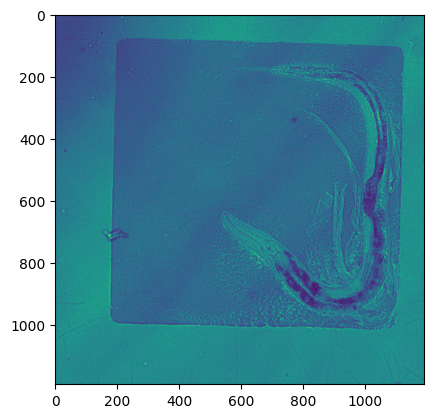

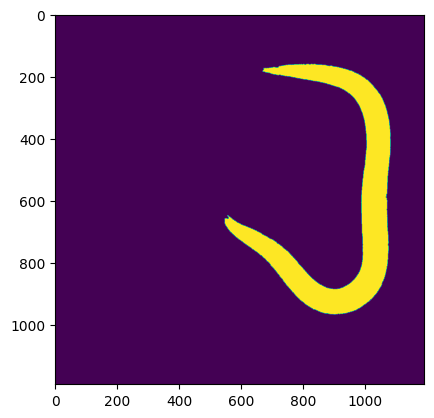

In [29]:
test_idx = 510

test_img = validation_dataframe.iloc[test_idx][image_column]
test_mask = validation_dataframe.iloc[test_idx][mask_column]

test_img = image_handling.read_tiff_file(test_img, [2])
test_mask = image_handling.read_tiff_file(test_mask)

plt.imshow(test_img)
plt.show()

plt.imshow(test_mask)
plt.show()

In [35]:
model_path = "/home/spsalmon/towbintools/towbintools/deep_learning/unet_lightning_test/epoch=21-step=11000.ckpt"
# model_path = "/home/spsalmon/towbintools/towbintools/deep_learning/unet_lightning_test/epoch=154-step=58125.ckpt"
checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
model = LightningPretrained.load_from_checkpoint(model_path, map_location=torch.device('cpu'))
model.eval()

LightningPretrained(
  (model): UnetPlusPlus(
    (encoder): EfficientNetEncoder(
      (_conv_stem): Conv2dStaticSamePadding(
        3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
        (static_padding): ZeroPad2d((0, 1, 0, 1))
      )
      (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_blocks): ModuleList(
        (0): MBConvBlock(
          (_depthwise_conv): Conv2dStaticSamePadding(
            48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
            (static_padding): ZeroPad2d((1, 1, 1, 1))
          )
          (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
          (_se_reduce): Conv2dStaticSamePadding(
            48, 12, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): Identity()
          )
          (_se_expand): Conv2dStaticSamePadding(
            12, 48, kernel_size=(1, 1), stride=(1, 1)
            (stat

In [36]:
def get_validation_augmentation(mean, std):
    test_transform = [
        albu.Normalize(mean=mean, std=std),
    ]
    return albu.Compose(test_transform)

tiler = ImageSlicer(test_img.shape, tile_size=(512, 512), tile_step=(256, 256), weight='pyramid')
test_img = get_validation_augmentation(mean_train_images, std_train_images)(image=test_img)['image']
test_tiles = tiler.split(test_img)


pred_tiles = []
for tile in test_tiles:
    tile = grayscale_to_rgb(tile)
    tile = tile.unsqueeze(0)
    prediction = model(tile)
    prediction = prediction.squeeze(0).detach().numpy()
    prediction = np.moveaxis(prediction, 0, -1)
    pred_tiles.append(prediction)
    print(prediction.shape)

(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)


In [37]:
merged_pred = tiler.merge(pred_tiles)

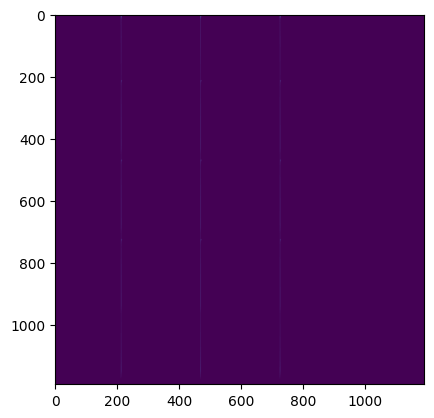

In [38]:
plt.imshow(merged_pred)
plt.show()